<a href="https://colab.research.google.com/github/beltima/minihack/blob/main/xiaoyan_RL_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Tutorial
# https://minihack.readthedocs.io/en/latest/tutorials/des_file_tutorial.html#The-Two-Types-of-des-files:-MAZE-and-ROOM

In [ ]:
!sudo apt-get install -y build-essential autoconf libtool pkg-config \
    python3-dev python3-pip python3-numpy git libncurses5-dev \
    libzmq3-dev flex bison
!git clone https://github.com/google/flatbuffers.git
!cd flatbuffers && cmake -G "Unix Makefiles" && make -j2 && sudo make install
!pip install cmake #==3.15.3

Reading package lists... Done
Building dependency tree       
Reading state information... Done
autoconf is already the newest version (2.69-11.1).
autoconf set to manually installed.
libncurses5-dev is already the newest version (6.2-0ubuntu2).
pkg-config is already the newest version (0.29.1-0ubuntu4).
python3-dev is already the newest version (3.8.2-0ubuntu2).
python3-dev set to manually installed.
libzmq3-dev is already the newest version (4.3.2-2ubuntu1).
build-essential is already the newest version (12.8ubuntu1.1).
git is already the newest version (1:2.25.1-1ubuntu3.10).
The following additional packages will be installed:
  libfl-dev libfl2 python-pip-whl python3-setuptools python3-wheel
Suggested packages:
  bison-doc flex-doc libtool-doc gcj-jdk python-numpy-doc python3-pytest
  python3-numpy-dbg python-setuptools-doc
The following NEW packages will be installed:
  bison flex libfl-dev libfl2 libtool python-pip-whl python3-numpy python3-pip
  python3-setuptools python3-wheel

In [ ]:
! pip install minihack

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.4/227.4 KB 13.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 80.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 624.4/624.4 KB 27.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-2.10.4-py3-none-any.whl (222 kB)
  Created wheel for minihack: filename=minihack-0.1.5-py3-none-any.whl size=265186 sha256=b6c5e1091ecec58aa06b27c61406c958347e029d2aeffc66bf70f96016c5b0d6


In [ ]:
# Copyright (c) Facebook, Inc. and its affiliates.

from minihack import MiniHackSkill
from nle.nethack.actions import MiscDirection
import PIL.Image
import PIL.ImageChops
import math


def get_image(pixel_obs, full_screen=False, resize=None, relative=False):
    image = PIL.Image.fromarray(pixel_obs)
    if not full_screen:
        bg = PIL.Image.new(image.mode, image.size, image.getpixel((0, 0)))
        diff = PIL.ImageChops.difference(image, bg)
        diff = PIL.ImageChops.add(diff, diff, 2.0, -100)
        bbox = diff.getbbox()
        if bbox:
            image = image.crop(bbox)

    if resize is not None:
        x_resize, y_resize = resize
        if relative:
            image = image.resize(
                (int(image.width * x_resize), int(image.height * y_resize))
            )
        else:
            image = image.resize((x_resize, y_resize))

    return image


def get_des_file_rendering(
    des_file,
    n_images=1,
    full_screen=False,
    full_obs=True,
    resize=None,
    relative=True,
    wizard=False,
):
    class MHCustom(MiniHackSkill):
        def __init__(self, *args, **kwargs):
            super().__init__(*args, des_file=des_file, **kwargs)

    def get_pixel_obs(env, full_obs=True):
        obs = env.reset()
        if full_obs and wizard:
            for c in (
                "#wizintrinsic\rt\r\r#wizmap\r#wizwish\r"
                + "a potion of object detection\r"
            ):
                obs, sds = env.env.step(ord(c))
            msg = (
                obs[env._original_observation_keys.index("message")]
                .tobytes()
                .decode("utf-8")
            )

            for c in f"q{msg[0]}":
                obs, sds = env.env.step(ord(c))

            obs, _, _, _ = env.step(env._actions.index(MiscDirection.WAIT))
        return obs

    env = MHCustom(
        savedir=None,
        observation_keys=("pixel",),
        wizard=wizard,
    )
    if n_images == 1:
        obs = get_pixel_obs(env, full_obs=full_obs)
        image = get_image(
            obs["pixel"],
            full_screen=full_screen,
            resize=resize,
            relative=relative,
        )
        return image
    else:
        images = []
        for _i in range(n_images):
            obs = get_pixel_obs(env, full_obs=full_obs)
            images.append(
                get_image(
                    obs["pixel"],
                    resize=resize,
                    relative=relative,
                    full_screen=full_screen,
                )
            )
        width = images[0].width
        height = images[0].height
        result = PIL.Image.new(
            "RGB",
            ((width * 3) + 10, ((height + 5) * math.ceil(n_images / 3)) - 5),
            color=(200, 200, 200),
        )
        for j in range(math.ceil(n_images / 3)):
            for i in range(3):
                try:
                    result.paste(
                        images[(j * 3) + i],
                        ((width + 5) * i, (height + 5) * j),
                    )
                except IndexError:
                    return result
        return result

# Explore the environment

Tutorial: https://minihack.readthedocs.io/en/latest/tutorials/des_file_tutorial.html

In [ ]:
# Importing helper visualisation functions
from minihack.tiles.rendering import get_des_file_rendering

import IPython.display
def render_des_file(des_file, **kwargs):
    image = get_des_file_rendering(des_file, **kwargs)
    IPython.display.display(image)

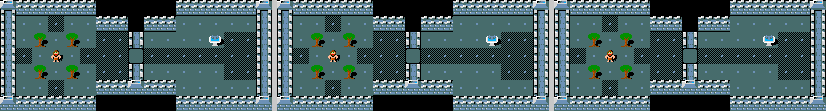

In [ ]:
# Maze type
des_file = """
MAZE: "mylevel", ' '
FLAGS:premapped
GEOMETRY:center,center
MAP
|-----     ------
|.....-- --.....|
|.T.T...-....K..|
|.......+.......|
|.T.T...-.......|
|.....-----.....|
|-----     ------
ENDMAP
BRANCH: (3,3,3,3),(4,4,4,4)
"""
render_des_file(des_file, n_images=3, full_screen=False)

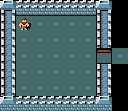

In [ ]:
des_file = """
MAZE: "mylevel",' '
GEOMETRY:center,center
MAP
-------------
|.....|.....|
|.....|.....|
|.....+.....|
|.....|.....|
|.....|.....|
-------------
ENDMAP
REGION:(0,0,12,6),lit,"ordinary"
BRANCH:(1,1,6,6),(0,0,0,0) 
DOOR:locked,(6,3)
STAIR:(8,3),down
"""
render_des_file(des_file, n_images=1, full_screen=False)

MAZE: "mylevel",' '：定义了一个名为 mylevel 的迷宫，并将墙壁字符设置为空格。

GEOMETRY:center,center：将迷宫在屏幕中央居中。
MAP：开始定义迷宫的地图布局。

```
-------------：定义迷宫地图的顶部和底部墙壁。
|.....|.....|：定义两个房间，用中央的竖线进行分隔，每个房间中间有一扇门。
|.....|.....|
|.....+.....|：定义连接两个房间的门，中心位置用 + 表示。
|.....|.....|：与第4行相同。
|.....|.....|
-------------：定义迷宫地图的顶部和底部墙壁。
```
ENDMAP：结束地图布局的定义。

REGION:(0,0,12,6),lit,"ordinary"：定义区域 (0,0)-(12,6)，使其在探索时始终可见（lit指照明状态），并将其标记为 "ordinary" 类型的区域。

BRANCH:(1,1,6,6),(0,0,0,0)：定义一个分支，其中 (1,1) 表示生成代理的位置，而 (6,6) 表示分支的另一端位置，即两个对角点确定一个区域。 (0,0,0,0) 表示此分支中代理不能访问的任何位置。

DOOR:locked,(6,3)：在 (6,3) 处创建一扇锁定的门，必须使用合适的钥匙才能打开。

STAIR:(8,3),down：在 (8,3) 处创建一个向下的楼梯，代理可以使用它进入下一个地下层。

Components(wall, corridor, etc.): https://nethackwiki.com/wiki/Des-file_format#Map_characters


```
Terrains = [
    " ",  # solid wall
    "#",  # corridor
    ".",  # room floor (Unlit, unless lit with REGION-command)
    "-",  # horizontal wall
    "|",  # vertical wall
    "+",  # door (State is defined with DOOR -command)
    "A",  # air
    "B",  # crosswall / boundary symbol hack (See REGION)
    "C",  # cloud
    "S",  # secret door
    "H",  # secret corridor
    "{",  # fountain
    "\\", # throne
    "K",  # sink
    "}",  # moat
    "P",  # pool of water
    "L",  # lava pool
    "I",  # ice
    "W",  # water
    "T",  # tree
    "F",  # iron bars
]
```



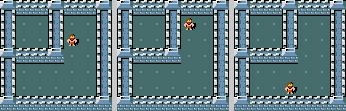

In [ ]:
# Room type
des_file = """  
LEVEL: "mylevel"
FLAGS: premapped

ROOM: "ordinary" , lit, (3,3), (center,center), (5,5) {
    SUBROOM: "ordinary", lit, (0,0), (2,2) {
    }
}

RANDOM_CORRIDORS
"""
render_des_file(des_file, n_images=3, full_screen=False)

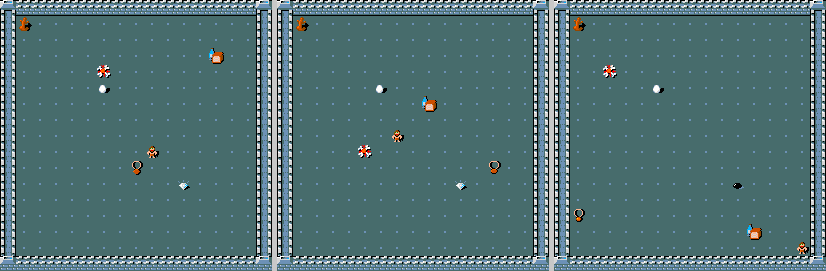

In [ ]:
# Monsters
des_file = """
LEVEL: "mylevel"
FLAGS: premapped
REGION: (0,0,20,80), lit, "ordinary"

ROOM: "ordinary", lit, random, (center,center), (15,15) {
    OBJECT:('%', "food ration"), random
    OBJECT:'*', (10,10)
    OBJECT :('"', "amulet of life saving"), random
    OBJECT:('%', "corpse"), random
    OBJECT:('`', "statue"), (0,0), montype:"forest centaur", 1
    OBJECT:('(', "crystal ball"), (17,08), blessed, 5,name:"The Orb of Fate"
    OBJECT:('%',"egg"), (05,04), montype:"yellow dragon"
}

RANDOM_CORRIDORS
"""
render_des_file(des_file, n_images=3)

# Build the evironment

In [ ]:
import gym
import minihack

des_file = """
MAZE: "mylevel",' '
GEOMETRY:center,center
MAP
-------------
|.....|.....|
|.....|.....|
|.....+.....|
|.....|.....|
|.....|.....|
-------------
ENDMAP
REGION:(0,0,12,6),lit,"ordinary"
BRANCH:(1,1,6,6),(0,0,0,0)
DOOR:locked,(6,3)
STAIR:(8,3),down
"""
env = gym.make(
    "MiniHack-Navigation-Custom-v0",
    des_file=des_file,
    max_episode_steps=50,
)

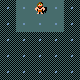

In [ ]:
get_des_file_rendering(des_file)